### Sequential neural posterior estimation

In [3]:
import numpyro.distributions as ndist
import numpyro
import jax.numpy as jnp
import jax.random as jr
from flowjax.train.data_fit import fit_to_data_sequential

def model(x_obs=None):
    with numpyro.plate("task_dim", 2):
        theta = numpyro.sample("theta", ndist.Normal(0, 1))
        component = numpyro.sample("c", ndist.Categorical(jnp.array([0.5])), infer={"enumerate": "parallel"})
        scale = jnp.where(component==0, 0.1, 0.5)
        numpyro.sample("x", ndist.Normal(theta, scale), obs=x_obs)

from numpyro.infer import Predictive
key, subkey = jr.split(jr.PRNGKey(0))
x_obs = Predictive(model, num_samples=1)(subkey)["x"][0]

### Sample reference posterior using numpyro and MCMC

In [4]:
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import jax.random as jr
mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=10000)
key, subkey = jr.split(key)
mcmc.run(subkey, x_obs)
reference_posterior = mcmc.get_samples()["theta"][::10]

sample: 100%|██████████| 11000/11000 [00:16<00:00, 685.46it/s, 1 steps of size 8.14e-01. acc. prob=0.93] 


### Infer approximate posterior using SNPE

In [ ]:
key, subkey = jr.split(jr.PRNGKey(0))
prior_predictive_samples = numpyro.infer.Predictive(model, num_samples=1000)(subkey)
theta_dim, x_dim = 2, 2

from flowjax.flows import MaskedAutoregressiveFlow
from flowjax.distributions import Normal
from flowjax.bijections import Affine
import jax.numpy as jnp

import jax
from jax import config

config.update("jax_debug_nans", False)
config.update("jax_debug_infs", False)


def simulate(key, theta):
    predictive = numpyro.infer.Predictive(model, {"theta": theta})
    return predictive(key)["x"]

key, subkey = jr.split(key)
proposal = MaskedAutoregressiveFlow(
    subkey,
    base_dist=Normal(jnp.zeros(theta_dim)),
    transformer=Affine(),
    cond_dim=x_dim,
    )

sim_per_round = 1000
prior = Normal(jnp.zeros(theta_dim))  # Matches prior from the model

round_samples = []
for r in range(3):
    # Carry out simulations (from prior for round 1, the running proposal otherwise).
    key, theta_key, x_key, train_key = jr.split(key, 4)
    key, subkey = jr.split(key)
    if r==0:
        theta_r = prior.sample(theta_key, (sim_per_round, ))
    else:
        theta_r = proposal.sample(theta_key, (sim_per_round, ), condition=x_obs)

    round_samples.append(theta_r)

    x_r = simulate(x_key, theta_r)
            
    key, subkey = jr.split(key)
    proposal, losses = fit_to_data_sequential(
        key=train_key,
        proposal=proposal,
        prior=prior,
        theta=theta_r,
        x_sim=x_r,
        x_obs=x_obs,
        is_first_round=r==0,
        learning_rate=1e-4,
        max_epochs=100,
        max_patience=3,
        )

key, subkey = jr.split(key)
round_samples.append(
    proposal.sample(theta_key, (sim_per_round, ), condition=x_obs)
)



  0%|          | 0/100 [00:10<?, ?it/s]


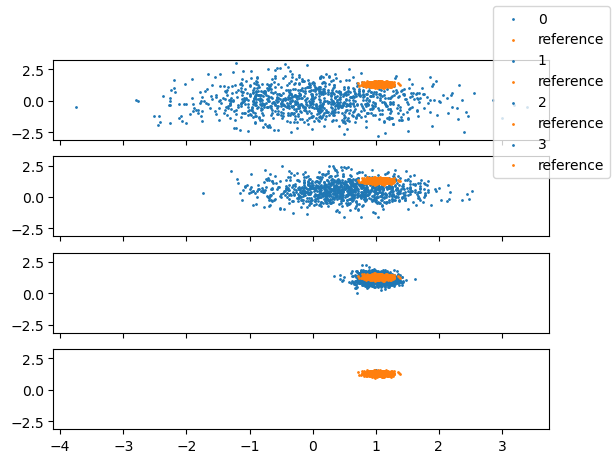

In [ ]:
fig, axes = plt.subplots(nrows=len(round_samples), sharex=True, sharey=True)

for r, (ax, samps) in enumerate(zip(axes, round_samples)):
    posterior_samples = proposal.sample(key, (1000, ), x_obs)
    ax.scatter(samps[:, 0], samps[:, 1], label=r, s=1)
    ax.scatter(reference_posterior[:, 0], reference_posterior[:, 1], label="reference", s=1)
fig.legend()